# Task: Quantum Circuit Simulator

In [145]:
import numpy as np
import math
import random
import json

In [2]:
def get_ground_state(num_qubits):
    # return vector of size 2**num_qubits with all zeroes except first element which is 1
    ground_state=np.zeros(2**num_qubits)
    ground_state[0]=1
    return ground_state

In the begining, all qubits are initialized to $\vert 0\rangle$ - i.e. our initial state is $ \vert\underbrace{ 00...0}_{\!\!\!\!\!\!\!\text{number of qubits}\!\!\!\!\!\!\!}\rangle$

Gates like $X$,$I$,$\vert{0}\rangle\!\langle{0}\vert$ or $\vert{1}\rangle\!\langle{1}\vert$ are going to be frequently used.

In [3]:
# Define gates used as building blocks for matrix operators:
X = np.array([[0, 1],
              [1, 0]])
    
I = np.identity(2)
    
#Projection operators |0><0| and |1><1|
P0x0 = np.array([[1, 0],
                 [0, 0]])
P1x1 = np.array([[0, 0],
                 [0, 1]])

Function $\bf cu$ returns matrix of the controlled unitary operator.

control_qubit argument is the position of the control qubit and target_qubit is the position of the qubit on which $2x2$ gate_unitary is applied.

It is an auxiliary function used to easily implement $\bf SWAP$ functoin for arbitrary qubits.

$\bf cu$ is implemented using operator decomposition into sum of Kronecker products, as derived for $CX$ case in [1]

$O = I\otimes I \otimes ... \otimes\vert{0}\rangle\!\langle{0}\vert\otimes I\otimes ... \otimes I\otimes I\otimes I \otimes... \otimes I + \\
I\otimes I \otimes ... \otimes\vert{1}\rangle\!\langle{1}\vert\otimes I\otimes ... \otimes I\otimes X\otimes I \otimes... \otimes I$

In [4]:
def cu(total_qubits, gate_unitary, control_qubit, target_qubit):
    
    gate_unitary=np.array(gate_unitary)
    
    if (np.abs(gate_unitary.dot(gate_unitary.conj().T))-I>0.000000000001).any():
        print("gate_unitary is not a unitary matrix.")
        return
    
    if control_qubit>=total_qubits:
        print("Control qubit is out of bounds.")
        return
    if target_qubit>=total_qubits:
        print("Target qubit is out of bounds.")
        return
    
    #Final operator is sum of Kronecker products of elements of the lists 'op_control' and 'op_target'
    op_control=[[1]]
    op_target=[[1]]
    for i in range(total_qubits):
        if i==control_qubit:
            A=P0x0
            B=P1x1
        elif i==target_qubit:
            A=I
            B=gate_unitary
        else:
            A=I
            B=I
        op_control=np.kron(op_control,A)
        op_target=np.kron(op_target,B)
    operator=op_control+op_target
    
    return operator

The swap gate swaps two qubits.

${SWAP} = \begin{bmatrix} 1 & 0 & 0 & 0 \\
                         0 & 0 & 1 & 0 \\
                         0 & 1 & 0 & 0 \\
                         0 & 0 & 0 & 1 \\
         \end{bmatrix}$
         
Although SWAP gate has a familiar matrix representation, it can be used only for 2 consecutive qubits.

Swaping 2 arbitrary qubits is achievable by compositions of shifted two-qubit SWAP gates, but it is rather tedious and it is not vital for simulators.

One possible decompositon of the SWAP gate is using three CX gates:

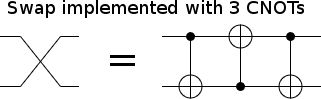

In [158]:
from IPython.display import Image, display
Image('img/xor-swap.png')

$SWAP(0,1)=CX(0,1)CX(1,0)CX(0,1)$

It can be quickly checked that this holds true for all four basis states, then by linearity, it holds true for any state.

Similarly, for any two qubits:

$SWAP(a,b)=CX(a,b)CX(b,a)CX(a,b)$

In [5]:
def swap(total_qubits, qubit1, qubit2):
    
    if(qubit1>=total_qubits or qubit2>=total_qubits):
        print("Qubit is out of bounds.")
        return
    
    operator = np.dot(np.dot(cu(total_qubits, X, qubit1, qubit2),cu(total_qubits, X, qubit2, qubit1)),
                      cu(total_qubits, X, qubit1, qubit2))
    
    return operator

$\bf mcu$ functon returns matrix operator for any number of total qubits, control qubits or target qubits.

If unitary gate should be applied to any number of target qubits, but is not using contol qubits, control_qubits argument should be set to [ ].

Otherwise, positions of control qubits can be provided in any order and similarly for target qubits. Only in cases when, for example, 2 qubit gate should be applied to 4 qubits, it is assumed that the first two and the second two qubits are targeted together.

This function handles multiple qubit gates for non-consecutive qubits in the following way:

- Let $n$ be the number of target qubits. Target qubits are swapped with last $n$ qubits. This way it is assured that the target qubits are adjacent as well as that there are no contol qubits between them, if any exist.

- Unitary gate is applied to last $n$ qubits.

- Target qubits are swapped back to original places using the same operator from step one, since SWAP is it's own inverse.

[2]

In [72]:
def mcu(total_qubits, gate_unitary, control_qubits, target_qubits):
    # return unitary operator of size 2**n x 2**n for given gate and target qubits
    
    gate_unitary=np.array(gate_unitary)
    
    if (np.abs(gate_unitary.dot(gate_unitary.conj().T))-np.identity(gate_unitary.shape[0])>0.000000000001).any():
        print("gate_unitary is not a unitary matrix")
        return
    
    if list(set(control_qubits) & set(target_qubits))!=[]:
        print("Qubit can not be both control and target.")
        return
    
    test_c=[a for a in control_qubits if a>=total_qubits]
    if test_c!=[]:
        print("Control qubit is out of bounds.")
        return
    test_t=[a for a in target_qubits if a>=total_qubits]
    if test_t!=[]:
        print("Target qubit is out of bounds.")
        return
    
    n=int(np.log2(gate_unitary.shape[0]))
    
    #if n>1, targeted qubits should be swaped to become adjacent to one another
    #asumming that the positions of the qubits, which should be targeted together, are adjacent in the input
    
    #creating swap operator
    swap_op=np.identity(2**total_qubits)
    
    m=len(target_qubits)
    
    if n>1:
        #safe way to ensure that the target qubits are consecutive and
        #that there are no control qubits between them is to swap
        #m target qubits with m final qubits.

        for i in range(m):
            M=swap(total_qubits,target_qubits[m-i-1],total_qubits-i-1)
            if total_qubits-i-1 in control_qubits:
                control_qubits[control_qubits.index(total_qubits-i-1)]=target_qubits[m-i-1]
            target_qubits[m-i-1]=total_qubits-i-1
            swap_op=np.dot(swap_op,M)
    
    
        
    #Creating a lists of elements involved in decomposition of the final operator
    # into sum od Kronecker products. Initialized to identities:
    
    lists=[[I]*total_qubits]*(2**len(control_qubits))

    controls=[P0x0,P1x1]
        
    for x in range(2**len(control_qubits)):
        i=0
        for y in control_qubits:
            binary=bin(x)
            try:
                lists[x][y]=controls[int(binary[len(binary)-1-i])]
            except ValueError:
                lists[x][y]=controls[0]
            i=i+1

        for k in range(int(m/n)):
            if x==2**len(control_qubits)-1:
                lists[x][target_qubits[k*n]]=gate_unitary
                for l in range(1,n):
                    lists[x][target_qubits[k*n+l]]=[[1]]
        lists[x]=list(lists[x])

        
    #Final operator is sum of Kronecker products od elements from the previously created lists
    list_op=[[1]]*(2**len(control_qubits))
    for i in range(total_qubits):
        for j in range(2**len(control_qubits)):
            list_op[j]=np.kron(list_op[j],lists[j][i])

        
    operator=list_op[0]
    for i in range(1,2**len(control_qubits)):
        operator=operator+list_op[i]   

    if(n>1):
        operator = np.dot(np.dot(swap_op,operator),swap_op)
        
    return operator

### Examples:

#### Hadamard  
$I \otimes H$

In [76]:
mcu(total_qubits=2, gate_unitary=[[1/np.sqrt(2),1/np.sqrt(2)],[1/np.sqrt(2),-1/np.sqrt(2)]],control_qubits=[],target_qubits=[1])

array([[ 0.70710678,  0.70710678,  0.        ,  0.        ],
       [ 0.70710678, -0.70710678,  0.        , -0.        ],
       [ 0.        ,  0.        ,  0.70710678,  0.70710678],
       [ 0.        , -0.        ,  0.70710678, -0.70710678]])

$ I \otimes H \otimes H $

In [84]:
mcu(total_qubits=3, gate_unitary=[[1/np.sqrt(2),1/np.sqrt(2)],[1/np.sqrt(2),-1/np.sqrt(2)]],control_qubits=[],target_qubits=[1,2])

array([[ 0.5,  0.5,  0.5,  0.5,  0. ,  0. ,  0. ,  0. ],
       [ 0.5, -0.5,  0.5, -0.5,  0. , -0. ,  0. , -0. ],
       [ 0.5,  0.5, -0.5, -0.5,  0. ,  0. , -0. , -0. ],
       [ 0.5, -0.5, -0.5,  0.5,  0. , -0. , -0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0.5,  0.5,  0.5,  0.5],
       [ 0. , -0. ,  0. , -0. ,  0.5, -0.5,  0.5, -0.5],
       [ 0. ,  0. , -0. , -0. ,  0.5,  0.5, -0.5, -0.5],
       [ 0. , -0. , -0. ,  0. ,  0.5, -0.5, -0.5,  0.5]])

#### CX

In [61]:
mcu(total_qubits=2, gate_unitary=X,control_qubits=[0],target_qubits=[1])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]])

#### Toffoli

In [60]:
mcu(total_qubits=3, gate_unitary=X,control_qubits=[0,1],target_qubits=[2])

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0.]])

#### CSWAP

In [59]:
mcu(total_qubits=3, gate_unitary=swap(2,0,1),control_qubits=[0],target_qubits=[1,2])

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

#### C(2)SWAP(0,1)SWAP(3,4)

In [85]:
mcu(total_qubits=5, gate_unitary=swap(2,0,1) ,control_qubits=[2],target_qubits=[0,1,3,4])

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [108]:
def run_program(initial_state, program):
    # read program, and for each gate:
    #   - calculate matrix operator
    #   - multiply state with operator
    # return final state
    state=initial_state
    
    for x in program:
        operator=mcu(total_qubits=int(np.log2(len(initial_state))),gate_unitary=x['unitary'],
                     control_qubits=x['control'],target_qubits=x['target'])
        
        state=np.dot(state,operator)    
    
    return state

In [126]:
my_circuit = [
{ "unitary": [[1/np.sqrt(2),1/np.sqrt(2)],[1/np.sqrt(2),-1/np.sqrt(2)]],"control": [], "target": [0] }, 
{ "unitary": [[0,1],[1,0]], "control": [0], "target": [1] }
]

In [134]:
run_program(get_ground_state(2),my_circuit)

array([0.70710678, 0.        , 0.        , 0.70710678])

In [136]:
def measure_all(state_vector):
    # choose element from state_vector using weighted random and return it's index
    
    choice = random.choices(range(len(state_vector)),weights=state_vector*np.conj(state_vector))
    
    return choice[0]

In [137]:
measure_all(run_program(get_ground_state(2),my_circuit))

0

In [153]:
def get_counts(state_vector, num_shots):
    # simply execute measure_all in a loop num_shots times and
    # return object with statistics in following form:
    #   {
    #      element_index: number_of_ocurrences,
    #      element_index: number_of_ocurrences,
    #      element_index: number_of_ocurrences,
    #      ...
    #   }
    # (only for elements which occoured - returned from measure_all)
    
    result=dict()
    n=int(np.log2(len(state_vector)))
    
    for i in range(num_shots):
        index=measure_all(state_vector)
        
        index=bin(index)[2:]
        if len(index)<n:
            index="0"*(n-len(index))+index
        
        if index not in result:
            result[index]=1
        else:
            result[index]=result[index]+1
    
    return json.dumps(result, indent=2**n)

In [154]:
counts=get_counts(run_program(get_ground_state(2),my_circuit),1000)

In [155]:
print(counts)

{
    "11": 504,
    "00": 496
}


### Example usage

Unitary gate in the following program is the gate which is applied only to target qubits. That is true for operators using control qubits as well, meaning that, for example, if $\bf CX$ gate should be in the circuit, only matrix for $ \bf X$ gate should be provided.

In [156]:
# Define program:

my_circuit = [
{ "unitary": [[1/np.sqrt(2),1/np.sqrt(2)],[1/np.sqrt(2),-1/np.sqrt(2)]],"control": [], "target": [0] }, 
{ "unitary": [[0,1],[1,0]], "control": [0], "target": [1] }
]


# Create "quantum computer" with 2 qubits (this is actually just a vector :) )

my_qpu = get_ground_state(2)


# Run circuit

final_state = run_program(my_qpu, my_circuit)


# Read results

counts = get_counts(final_state, 1000)

print(counts)

{
    "11": 505,
    "00": 495
}


### References:

[1] - [qosf-simulator-task-additional-info.pdf](https://github.com/quantastica/qosf-mentorship/blob/master/qosf-simulator-task-additional-info.pdf)

[2] - [G. Sergioli - Quantum circuit optimization for unitary operators overnon-adjacent qudits](https://arxiv.org/pdf/1711.09765.pdf)